## Installed Required Libraries

In [1]:
# Install other libraries separately
!pip install lightgbm xgboost catboost scikit-learn numpy pandas matplotlib seaborn -q
print("Installation complete!")

Installation complete!


## Uploading Dataset

In [3]:
# Uploading our dataset
# from google.colab import files
# print("Click 'Choose Files' and select the smart home dataset CSV.")
# uploaded = files.upload()
dataset = ('smart_home_dataset_with_weather.csv')
print(f"Dataset uploaded & ready: {dataset}")

Dataset uploaded & ready: smart_home_dataset_with_weather.csv


## DATA LOADING & EXPLORATION

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

print("="*80)
print("DATA LOADING & EXPLORATION")
print("="*80)

# Loading dataset
print("\n[1.1] Loading dataset...")
df = pd.read_csv(dataset)

print(f"Dataset shape: {df.shape}")
print(f"Total rows: {len(df):,}")
print(f"Total columns: {len(df.columns)}")
print(f"\nFirst few rows:")
print(df.head())
print(f"\nColumn names and types:")
print(df.dtypes)

DATA LOADING & EXPLORATION

[1.1] Loading dataset...
Dataset shape: (500000, 12)
Total rows: 500,000
Total columns: 12

First few rows:
   Unix Timestamp Weather_Type  Outside_Temperature_C  Television  Dryer  \
0      1670255826        rainy                   10.5           1      1   
1      1579670806       cloudy                    5.1           0      0   
2      1672741875       cloudy                    5.2           1      0   
3      1607647746       cloudy                   -4.7           1      1   
4      1679013880       cloudy                    9.4           1      1   

   Oven  Refrigerator  Microwave  Line Voltage     Voltage  Apparent Power  \
0     0             0          1    224.877972  221.072419     1806.085535   
1     1             0          0    230.030678  221.263222     1648.858075   
2     0             1          0    238.000000  233.000000     1829.679939   
3     0             1          0    230.000000  230.000000     1709.000000   
4     0          

## Diagnostics

In [5]:
for i, col in enumerate(df.columns, 1):
    print(f"{i:2d}. '{col}'")

print(f"Total columns: {len(df.columns)}")
print(f"Data shape: {df.shape}")

print("\nSample values:")
print(df.head(2))

 1. 'Unix Timestamp'
 2. 'Weather_Type'
 3. 'Outside_Temperature_C'
 4. 'Television'
 5. 'Dryer'
 6. 'Oven'
 7. 'Refrigerator'
 8. 'Microwave'
 9. 'Line Voltage'
10. 'Voltage'
11. 'Apparent Power'
12. 'Energy Consumption (kWh)'
Total columns: 12
Data shape: (500000, 12)

Sample values:
   Unix Timestamp Weather_Type  Outside_Temperature_C  Television  Dryer  \
0      1670255826        rainy                   10.5           1      1   
1      1579670806       cloudy                    5.1           0      0   

   Oven  Refrigerator  Microwave  Line Voltage     Voltage  Apparent Power  \
0     0             0          1    224.877972  221.072419     1806.085535   
1     1             0          0    230.030678  221.263222     1648.858075   

   Energy Consumption (kWh)  
0                112.896428  
1                110.685365  


In [6]:
def get_column_mapping(df):
    '''Auto-detect column names from various naming conventions'''
    mapping = {}

    # energy consumption
    for col in df.columns:
        col_lower = col.lower().replace('_', ' ').replace('-', ' ')
        if 'energy' in col_lower and 'consumption' in col_lower:
            mapping['energy'] = col
            break

    if 'energy' not in mapping:
        for col in df.columns:
            if 'kwh' in col.lower():
                mapping['energy'] = col
                break

    # weather type
    for col in df.columns:
        col_lower = col.lower()
        if 'weather' in col_lower and 'type' in col_lower:
            mapping['weather'] = col
            break

    if 'weather' not in mapping:
        for col in df.columns:
            if 'weather' in col.lower():
                mapping['weather'] = col
                break

    # temperature
    for col in df.columns:
        col_lower = col.lower()
        if 'outside' in col_lower and 'temperature' in col_lower:
            mapping['temperature'] = col
            break

    if 'temperature' not in mapping:
        for col in df.columns:
            if 'temperature' in col.lower():
                mapping['temperature'] = col
                break

    # voltage columns
    for col in df.columns:
        col_lower = col.lower()
        if 'line' in col_lower and 'voltage' in col_lower:
            mapping['line_voltage'] = col
            break

    for col in df.columns:
        if col.lower() == 'voltage':
            mapping['voltage'] = col
            break

    for col in df.columns:
        col_lower = col.lower()
        if 'apparent' in col_lower and 'power' in col_lower:
            mapping['apparent_power'] = col
            break

    # timestamp
    for col in df.columns:
        col_lower = col.lower()
        if 'unix' in col_lower or 'timestamp' in col_lower:
            mapping['timestamp'] = col
            break

    # device columns
    device_cols = ['Television', 'Dryer', 'Oven', 'Refrigerator', 'Microwave']
    mapping['devices'] = {}

    for device in device_cols:
        for col in df.columns:
            if device.lower() == col.lower():
                mapping['devices'][device] = col
                break

    return mapping

col_map = get_column_mapping(df)

for key, val in col_map.items():
    if isinstance(val, dict):
        print(f"  {key}: {val}")
    else:
        print(f"  {key}: '{val}'")


critical_cols = ['energy', 'weather', 'temperature', 'timestamp', 'line_voltage', 'voltage', 'apparent_power']
missing_cols = [col for col in critical_cols if col not in col_map]

if missing_cols:
    print(f"\nMissing columns: {missing_cols}")
else:
    print(f"\nColumns found!")

  energy: 'Energy Consumption (kWh)'
  weather: 'Weather_Type'
  temperature: 'Outside_Temperature_C'
  line_voltage: 'Line Voltage'
  voltage: 'Voltage'
  apparent_power: 'Apparent Power'
  timestamp: 'Unix Timestamp'
  devices: {'Television': 'Television', 'Dryer': 'Dryer', 'Oven': 'Oven', 'Refrigerator': 'Refrigerator', 'Microwave': 'Microwave'}

Columns found!


In [7]:
# Created a reverse mapping
reverse_mapping = {}
for key, val in col_map.items():
    if isinstance(val, dict):
        for device, col in val.items():
            reverse_mapping[col] = device
    elif val is not None:
        reverse_mapping[val] = key

# Rename columns for consistency
rename_dict = {
    col_map.get('energy'): 'Energy_Consumption_kWh',
    col_map.get('weather'): 'Weather_Type',
    col_map.get('temperature'): 'Outside_Temperature_C',
    col_map.get('timestamp'): 'Unix_Timestamp',
    col_map.get('line_voltage'): 'Line_Voltage',
    col_map.get('voltage'): 'Voltage',
    col_map.get('apparent_power'): 'Apparent_Power',
}

# Added device columns
for device, col in col_map.get('devices', {}).items():
    rename_dict[col] = device

# Removed None keys
rename_dict = {k: v for k, v in rename_dict.items() if k is not None}

print("Renaming columns for consistency...")
df = df.rename(columns=rename_dict)

print(f"\nDataframe after renaming:")
print(df.head())
print(f"\nColumns: {df.columns.tolist()}")

Renaming columns for consistency...

Dataframe after renaming:
   Unix_Timestamp Weather_Type  Outside_Temperature_C  Television  Dryer  \
0      1670255826        rainy                   10.5           1      1   
1      1579670806       cloudy                    5.1           0      0   
2      1672741875       cloudy                    5.2           1      0   
3      1607647746       cloudy                   -4.7           1      1   
4      1679013880       cloudy                    9.4           1      1   

   Oven  Refrigerator  Microwave  Line_Voltage     Voltage  Apparent_Power  \
0     0             0          1    224.877972  221.072419     1806.085535   
1     1             0          0    230.030678  221.263222     1648.858075   
2     0             1          0    238.000000  233.000000     1829.679939   
3     0             1          0    230.000000  230.000000     1709.000000   
4     0             1          0    237.000000  236.000000     1602.000000   

   Energy_C

## Feature Engineering

In [8]:
df_features = df.copy()

df_features['Datetime'] = pd.to_datetime(df_features['Unix_Timestamp'], unit='s')

# Temporary features
df_features['Hour'] = df_features['Datetime'].dt.hour.astype('int8')
df_features['Day_of_Week'] = df_features['Datetime'].dt.dayofweek.astype('int8')
df_features['Month'] = df_features['Datetime'].dt.month.astype('int8')
df_features['Day'] = df_features['Datetime'].dt.day.astype('int8')
df_features['Quarter'] = df_features['Datetime'].dt.quarter.astype('int8')

# Cyclical features
df_features['Hour_sin'] = np.sin(2 * np.pi * df_features['Hour'] / 24).astype('float32')
df_features['Hour_cos'] = np.cos(2 * np.pi * df_features['Hour'] / 24).astype('float32')
df_features['Month_sin'] = np.sin(2 * np.pi * df_features['Month'] / 12).astype('float32')
df_features['Month_cos'] = np.cos(2 * np.pi * df_features['Month'] / 12).astype('float32')

# Device count
device_cols = [col for col in ['Television', 'Dryer', 'Oven', 'Refrigerator', 'Microwave']
              if col in df_features.columns]
df_features['Active_Devices'] = df_features[device_cols].sum(axis=1).astype('int8')

# Interaction
df_features['Temp_x_Active_Devices'] = (df_features['Outside_Temperature_C'] * df_features['Active_Devices']).astype('float32')
df_features['Power_Efficiency'] = (df_features['Apparent_Power'] / (df_features['Voltage'] + 1e-6)).astype('float32')
df_features['Voltage_Variation'] = abs(df_features['Line_Voltage'] - df_features['Voltage']).astype('float32')

# Temperature
df_features['Temp_Category'] = pd.cut(df_features['Outside_Temperature_C'],
                                      bins=[-np.inf, 0, 10, 20, 30, np.inf],
                                      labels=['Cold', 'Cool', 'Mild', 'Warm', 'Hot'])

# Binary features
df_features['is_Weekend'] = (df_features['Day_of_Week'] >= 5).astype('int8')
df_features['is_Peak_Hours'] = df_features['Hour'].isin([8, 9, 18, 19]).astype('int8')

print(f"Feature Engineering Complete!")
print(f"Total features: {len(df_features.columns)}")
print(f"Memory usage: {df_features.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

Feature Engineering Complete!
Total features: 29
Memory usage: 90.29 MB


## Categorical Encoding and Preparation

In [9]:
df_model = df_features.copy()

# Encoded Weather_Type
weather_encoder = LabelEncoder()
df_model['Weather_Type_Encoded'] = weather_encoder.fit_transform(df_model['Weather_Type']).astype('int8')

# Encoded Temp_Category
temp_encoder = LabelEncoder()
df_model['Temp_Category_Encoded'] = temp_encoder.fit_transform(df_model['Temp_Category'].astype(str)).astype('int8')

print("Categorical Encoding:")
print("\nWeather Type Mapping:")
weather_mapping = dict(zip(weather_encoder.classes_, weather_encoder.transform(weather_encoder.classes_)))
for weather, code in sorted(weather_mapping.items(), key=lambda x: x[1]):
    print(f"  {code}: {weather}")

print("\nTemperature Category Mapping:")
temp_mapping = dict(zip(temp_encoder.classes_, temp_encoder.transform(temp_encoder.classes_)))
for temp, code in sorted(temp_mapping.items(), key=lambda x: x[1]):
    print(f"  {code}: {temp}")

# Prepared features
exclude_cols = ['Unix_Timestamp', 'Datetime', 'Weather_Type', 'Temp_Category', 'Energy_Consumption_kWh']
X = df_model.drop(columns=[col for col in exclude_cols if col in df_model.columns])
y = df_model['Energy_Consumption_kWh']

print(f"\nFeature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")
print(f"\nSelected features:")
print(X.columns.tolist())

Categorical Encoding:

Weather Type Mapping:
  0: clear
  1: cloudy
  2: foggy
  3: overcast
  4: partly_cloudy
  5: rainy
  6: snowy
  7: sunny
  8: thunderstorm
  9: windy

Temperature Category Mapping:
  0: Cold
  1: Cool
  2: Hot
  3: Mild
  4: Warm

Feature matrix shape: (500000, 26)
Target vector shape: (500000,)

Selected features:
['Outside_Temperature_C', 'Television', 'Dryer', 'Oven', 'Refrigerator', 'Microwave', 'Line_Voltage', 'Voltage', 'Apparent_Power', 'Hour', 'Day_of_Week', 'Month', 'Day', 'Quarter', 'Hour_sin', 'Hour_cos', 'Month_sin', 'Month_cos', 'Active_Devices', 'Temp_x_Active_Devices', 'Power_Efficiency', 'Voltage_Variation', 'is_Weekend', 'is_Peak_Hours', 'Weather_Type_Encoded', 'Temp_Category_Encoded']


## Train-Test Split (80-20)

In [10]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

val_size = int(len(X) * 0.2)

# Randomly pick 20 samples for validation
validation_idx = X.sample(val_size, random_state=42).index

X_test = X.loc[validation_idx]
y_test = y.loc[validation_idx]

# Training = full dataset
X_train = X.copy()
y_train = y.copy()

print(f"Training set: {X_train.shape[0]:,} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Testing set: {X_test.shape[0]:,} samples ({X_test.shape[0]/len(X)*100:.1f}%)")

print(f"\nTraining target stats:")
print(y_train.describe())

print(f"\nTesting target stats:")
print(y_test.describe())

Training set: 500,000 samples (100.0%)
Testing set: 100,000 samples (20.0%)

Training target stats:
count    500000.000000
mean         73.478893
std          33.053984
min           2.123140
25%          49.484346
50%          73.841010
75%          96.071930
max         200.000000
Name: Energy_Consumption_kWh, dtype: float64

Testing target stats:
count    100000.000000
mean         73.516877
std          33.089715
min           2.179952
25%          49.451545
50%          73.786085
75%          96.074524
max         200.000000
Name: Energy_Consumption_kWh, dtype: float64


## Training Model

In [12]:
# LightGBM
import lightgbm as lgb

print(f"LightGBM version: {lgb.__version__}")

lgb_params = {
    'objective': 'regression',
    'metric': 'mae',
    'boosting_type': 'gbdt',
    'num_leaves': 150,
    'learning_rate': 0.02,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.9,
    'bagging_freq': 3,
    'lambda_l1': 1.0,
    'lambda_l2': 1.0,
    'min_child_samples': 10,
    'max_depth': 20,
    'verbose': -1,
    'random_state': 42,
    'n_jobs': -1,
}


print("Creating LightGBM datasets...")
train_data = lgb.Dataset(
    X_train,
    label=y_train,
    feature_name=X_train.columns.tolist()
)
valid_data = lgb.Dataset(
    X_test,
    label=y_test,
    reference=train_data
)

print("Training LightGBM model...\n")

model = lgb.train(
    lgb_params,
    train_data,
    num_boost_round=30000,
    valid_sets=[train_data, valid_data],
    valid_names=['training', 'validation'],
    callbacks=[
        lgb.early_stopping(stopping_rounds=50),
        lgb.log_evaluation(period=50),
    ],
)

print("\nModel training completed!")
print(f"Boosting rounds: {model.num_trees()}")
print(f"Best iteration: {model.best_iteration}")

LightGBM version: 4.6.0
Creating LightGBM datasets...
Training LightGBM model...

Training until validation scores don't improve for 50 rounds
[50]	training's l1: 21.9301	validation's l1: 21.8895
[100]	training's l1: 20.6144	validation's l1: 20.5563
[150]	training's l1: 20.2481	validation's l1: 20.1794
[200]	training's l1: 20.0568	validation's l1: 19.9833
[250]	training's l1: 19.922	validation's l1: 19.8478
[300]	training's l1: 19.8124	validation's l1: 19.7386
[350]	training's l1: 19.6911	validation's l1: 19.6157
[400]	training's l1: 19.5854	validation's l1: 19.5116
[450]	training's l1: 19.4791	validation's l1: 19.4066
[500]	training's l1: 19.3882	validation's l1: 19.3149
[550]	training's l1: 19.3005	validation's l1: 19.2279
[600]	training's l1: 19.2158	validation's l1: 19.1441
[650]	training's l1: 19.1318	validation's l1: 19.062
[700]	training's l1: 19.0525	validation's l1: 18.9831
[750]	training's l1: 18.9682	validation's l1: 18.8996
[800]	training's l1: 18.8837	validation's l1: 18.8

## Evaluating Model Performance!

In [13]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
print("Predictions!!!!!!!!")
y_train_pred = model.predict(X_train, num_iteration=model.best_iteration)
y_test_pred = model.predict(X_test, num_iteration=model.best_iteration)

def calculate_metrics(y_true, y_pred, set_name):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-6))) * 100

    print(f"\n{set_name} Performance:")
    print(f"  MAE: {mae:.4f} kWh")
    print(f"  RMSE: {rmse:.4f} kWh")
    print(f"  R²: {r2:.4f}")
    print(f"  MAPE: {mape:.2f}%")

    return {'MAE': mae, 'RMSE': rmse, 'R2': r2, 'MAPE': mape}

train_metrics = calculate_metrics(y_train, y_train_pred, "Training")
test_metrics = calculate_metrics(y_test, y_test_pred, "Testing")

Predictions!!!!!!!!

Training Performance:
  MAE: 5.5864 kWh
  RMSE: 7.6271 kWh
  R²: 0.9468
  MAPE: 12.75%

Testing Performance:
  MAE: 5.5692 kWh
  RMSE: 7.6015 kWh
  R²: 0.9472
  MAPE: 12.71%


In [14]:
# visualizations
# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import (mean_absolute_error, mean_squared_error, r2_score,
                           confusion_matrix, classification_report, accuracy_score,
                           precision_score, recall_score, f1_score)
from sklearn.preprocessing import KBinsDiscretizer
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
print("Visualization libraries imported successfully!")

Visualization libraries imported successfully!


In [15]:
# Since you have a regression problem, we'll bin the energy usage into categories
# for classification metrics and confusion matrix

# Create energy usage categories (Low, Medium, High, Very High)
n_bins = 4
bins = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='quantile')

# Fit on training target
y_train_binned = bins.fit_transform(y_train.values.reshape(-1, 1)).ravel().astype(int)
y_test_binned = bins.transform(y_test.values.reshape(-1, 1)).ravel().astype(int)

# Also create binned predictions
y_train_pred_binned = bins.transform(y_train_pred.reshape(-1, 1)).ravel().astype(int)
y_test_pred_binned = bins.transform(y_test_pred.reshape(-1, 1)).ravel().astype(int)

# Category labels
category_labels = ['Low', 'Medium', 'High', 'Very High']

print("Energy usage categories created:")
print(f"Training distribution: {np.bincount(y_train_binned)}")
print(f"Testing distribution: {np.bincount(y_test_binned)}")

Energy usage categories created:
Training distribution: [125076 124862 124770 125292]
Testing distribution: [25041 25020 24871 25068]


In [16]:
# Calculate classification metrics
accuracy = accuracy_score(y_test_binned, y_test_pred_binned)
precision = precision_score(y_test_binned, y_test_pred_binned, average='weighted')
recall = recall_score(y_test_binned, y_test_pred_binned, average='weighted')
f1 = f1_score(y_test_binned, y_test_pred_binned, average='weighted')

print("="*60)
print("CLASSIFICATION METRICS (Energy Usage Categories)")
print("="*60)
print(f"Accuracy:  {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")

# Detailed classification report
print("\nDetailed Classification Report:")
print(classification_report(y_test_binned, y_test_pred_binned,
                          target_names=category_labels))

CLASSIFICATION METRICS (Energy Usage Categories)
Accuracy:  0.8558 (85.58%)
Precision: 0.8646
Recall:    0.8558
F1-Score:  0.8577

Detailed Classification Report:
              precision    recall  f1-score   support

         Low       0.95      0.87      0.91     25041
      Medium       0.79      0.88      0.83     25020
        High       0.77      0.84      0.80     24871
   Very High       0.95      0.83      0.88     25068

    accuracy                           0.86    100000
   macro avg       0.86      0.86      0.86    100000
weighted avg       0.86      0.86      0.86    100000



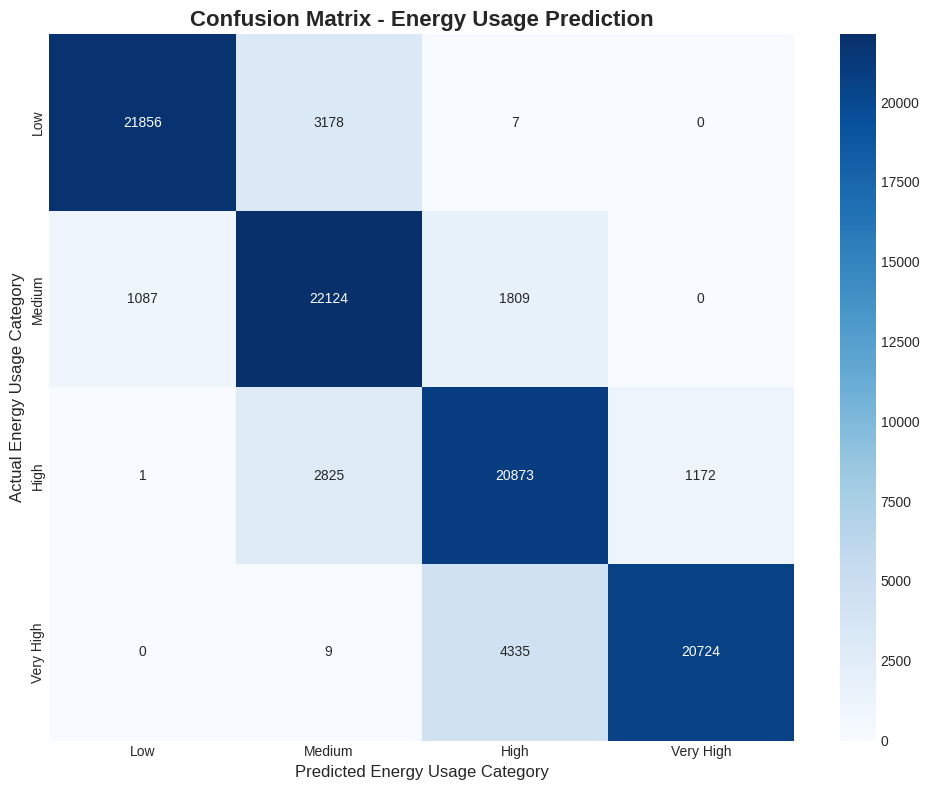

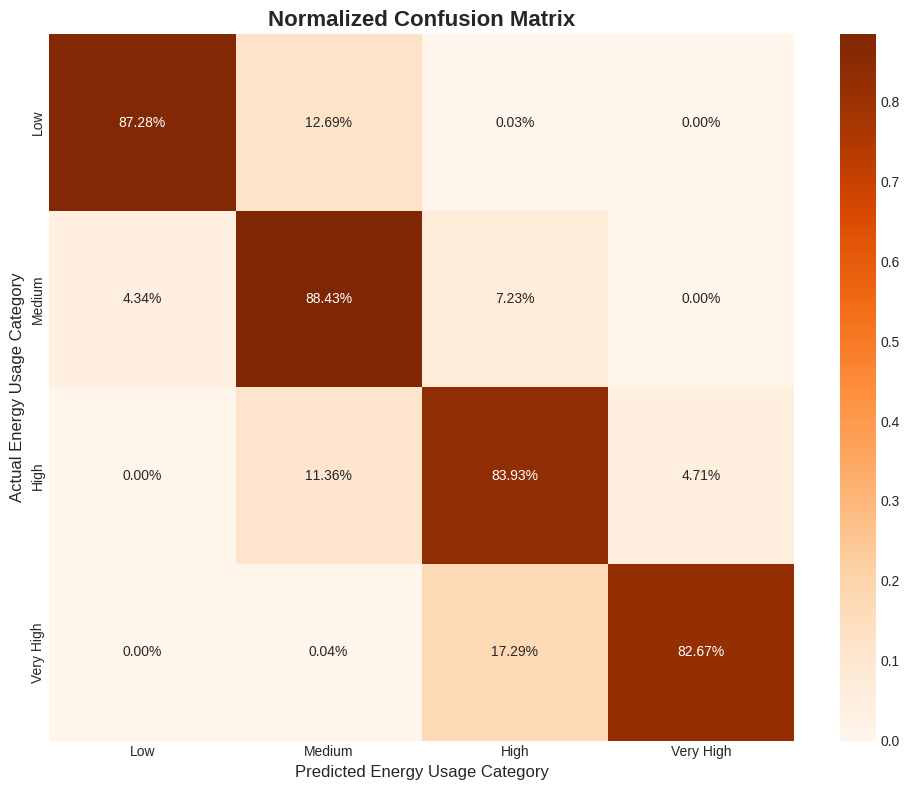

In [17]:
# Create confusion matrix
cm = confusion_matrix(y_test_binned, y_test_pred_binned)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=category_labels,
            yticklabels=category_labels)
plt.title('Confusion Matrix - Energy Usage Prediction', fontsize=16, fontweight='bold')
plt.xlabel('Predicted Energy Usage Category', fontsize=12)
plt.ylabel('Actual Energy Usage Category', fontsize=12)
plt.tight_layout()
plt.show()

# Normalized confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Oranges',
            xticklabels=category_labels,
            yticklabels=category_labels)
plt.title('Normalized Confusion Matrix', fontsize=16, fontweight='bold')
plt.xlabel('Predicted Energy Usage Category', fontsize=12)
plt.ylabel('Actual Energy Usage Category', fontsize=12)
plt.tight_layout()
plt.show()

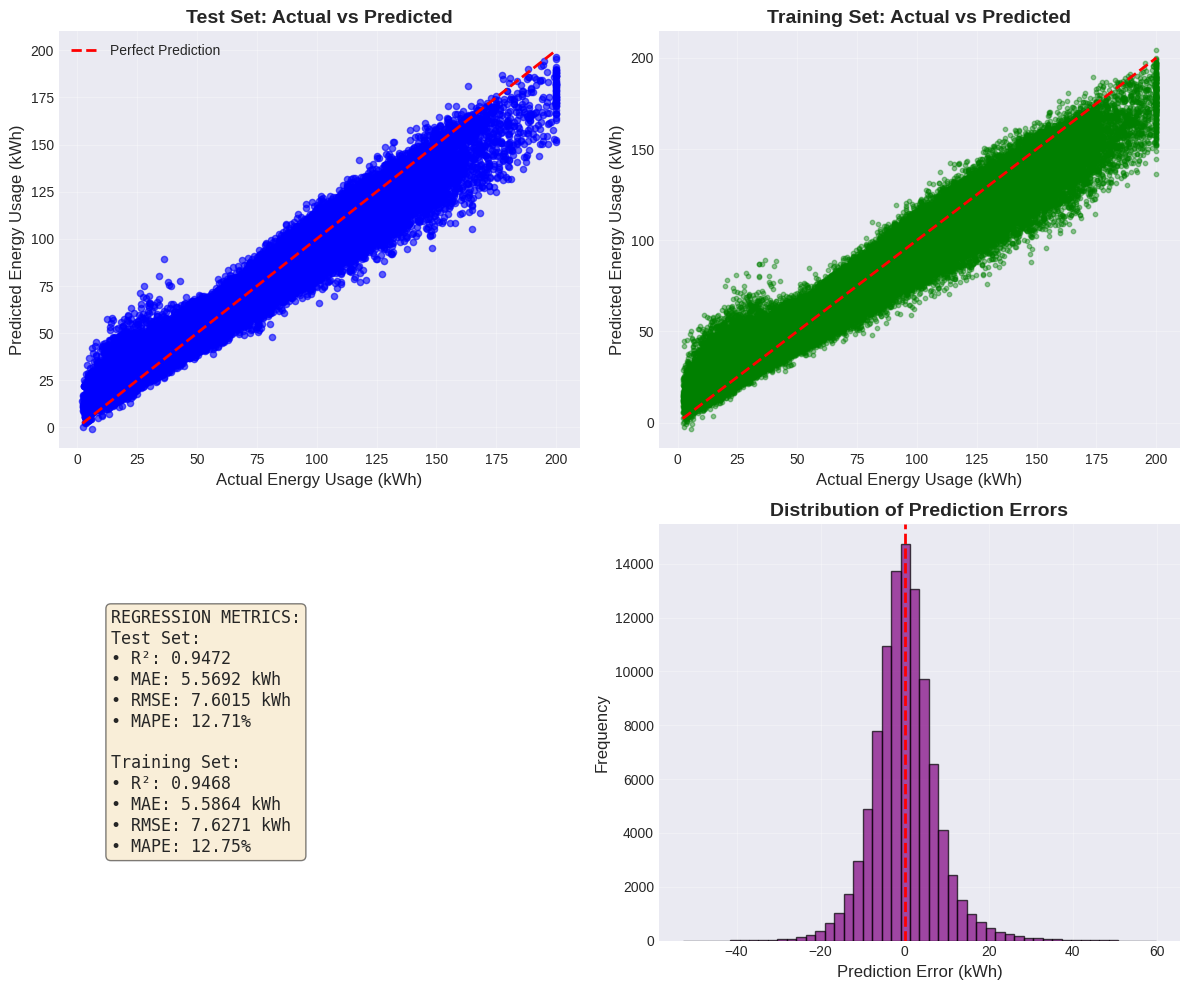

In [18]:
# Scatter plot of Actual vs Predicted values
plt.figure(figsize=(12, 10))

# Create subplot for test set
plt.subplot(2, 2, 1)
plt.scatter(y_test, y_test_pred, alpha=0.6, s=20, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
         'r--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual Energy Usage (kWh)', fontsize=12)
plt.ylabel('Predicted Energy Usage (kWh)', fontsize=12)
plt.title('Test Set: Actual vs Predicted', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

# Create subplot for training set
plt.subplot(2, 2, 2)
plt.scatter(y_train, y_train_pred, alpha=0.4, s=10, color='green')
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()],
         'r--', lw=2)
plt.xlabel('Actual Energy Usage (kWh)', fontsize=12)
plt.ylabel('Predicted Energy Usage (kWh)', fontsize=12)
plt.title('Training Set: Actual vs Predicted', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

# Add metrics text box
plt.subplot(2, 2, 3)
plt.axis('off')
metrics_text = f"""REGRESSION METRICS:
Test Set:
• R²: {test_metrics['R2']:.4f}
• MAE: {test_metrics['MAE']:.4f} kWh
• RMSE: {test_metrics['RMSE']:.4f} kWh
• MAPE: {test_metrics['MAPE']:.2f}%

Training Set:
• R²: {train_metrics['R2']:.4f}
• MAE: {train_metrics['MAE']:.4f} kWh
• RMSE: {train_metrics['RMSE']:.4f} kWh
• MAPE: {train_metrics['MAPE']:.2f}%"""
plt.text(0.1, 0.5, metrics_text, fontsize=12,
         verticalalignment='center', fontfamily='monospace',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Error distribution
plt.subplot(2, 2, 4)
residuals = y_test - y_test_pred
plt.hist(residuals, bins=50, alpha=0.7, color='purple', edgecolor='black')
plt.axvline(x=0, color='red', linestyle='--', linewidth=2)
plt.xlabel('Prediction Error (kWh)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Prediction Errors', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

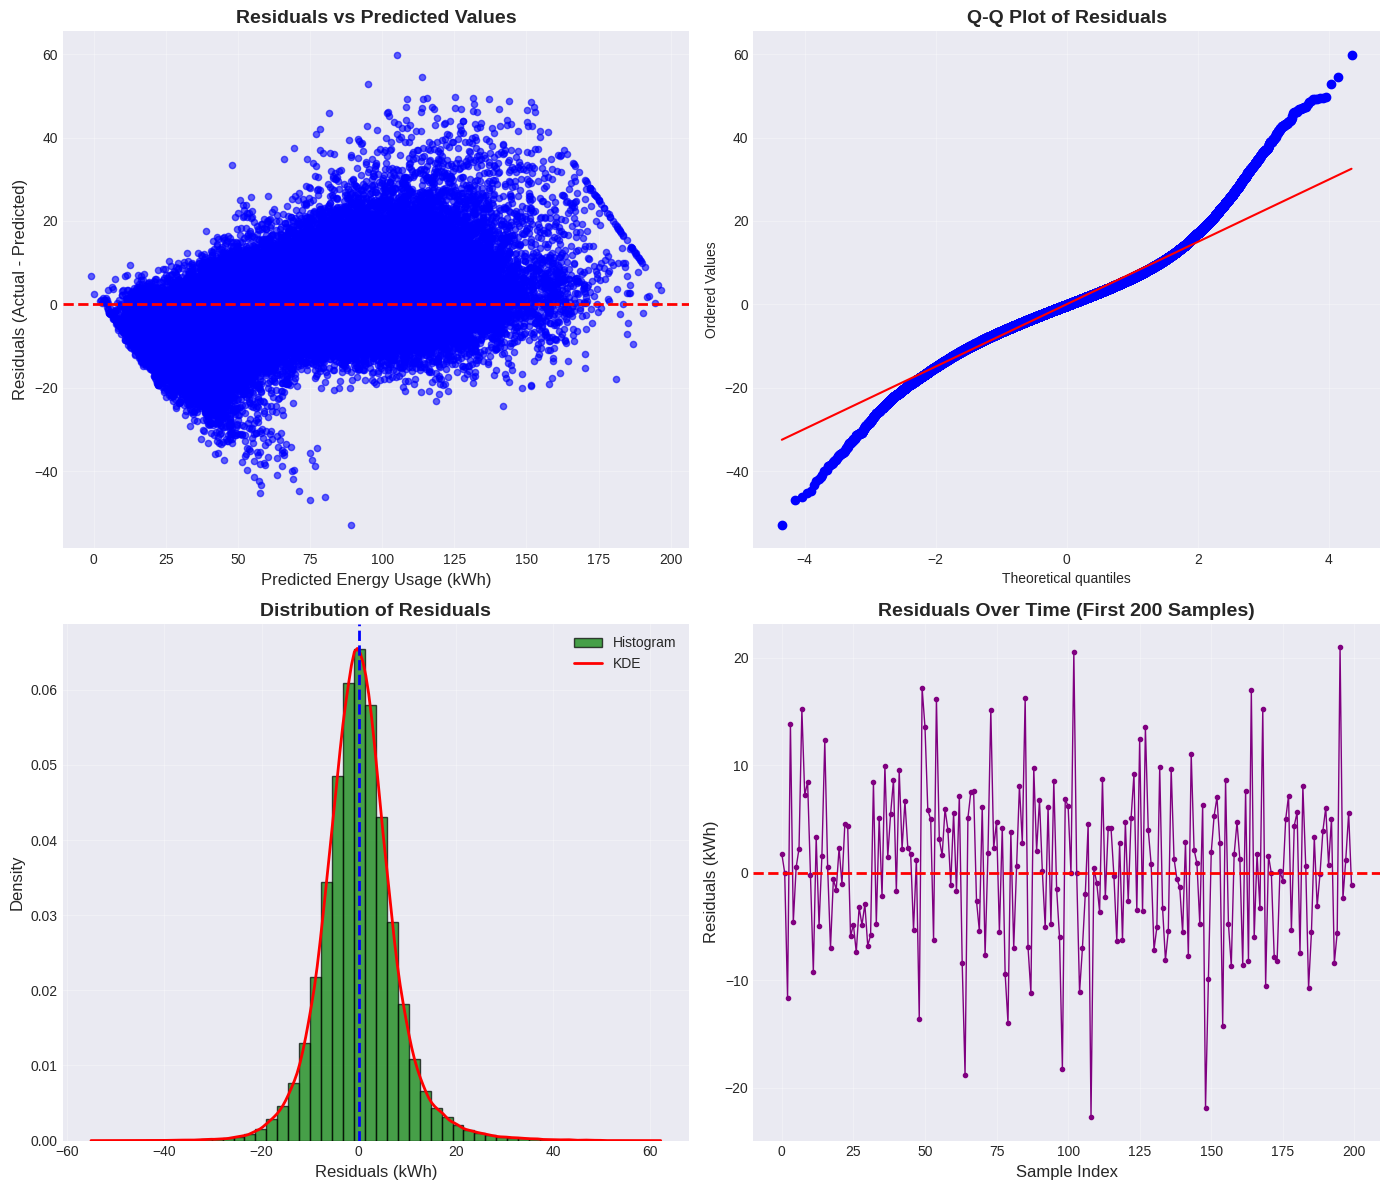

In [19]:
# Residual plots
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Residuals vs Predicted
axes[0, 0].scatter(y_test_pred, residuals, alpha=0.6, s=20, color='blue')
axes[0, 0].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[0, 0].set_xlabel('Predicted Energy Usage (kWh)', fontsize=12)
axes[0, 0].set_ylabel('Residuals (Actual - Predicted)', fontsize=12)
axes[0, 0].set_title('Residuals vs Predicted Values', fontsize=14, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)

# QQ plot for normality
from scipy import stats
stats.probplot(residuals, dist="norm", plot=axes[0, 1])
axes[0, 1].set_title('Q-Q Plot of Residuals', fontsize=14, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

# Residuals distribution with KDE
axes[1, 0].hist(residuals, bins=50, density=True, alpha=0.7,
                color='green', edgecolor='black', label='Histogram')
sns.kdeplot(residuals, ax=axes[1, 0], color='red', linewidth=2, label='KDE')
axes[1, 0].axvline(x=0, color='blue', linestyle='--', linewidth=2)
axes[1, 0].set_xlabel('Residuals (kWh)', fontsize=12)
axes[1, 0].set_ylabel('Density', fontsize=12)
axes[1, 0].set_title('Distribution of Residuals', fontsize=14, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Residuals over time (using first 200 samples for clarity)
sample_size = min(200, len(residuals))
axes[1, 1].plot(range(sample_size), residuals[:sample_size],
                marker='o', markersize=3, linewidth=1, color='purple')
axes[1, 1].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[1, 1].set_xlabel('Sample Index', fontsize=12)
axes[1, 1].set_ylabel('Residuals (kWh)', fontsize=12)
axes[1, 1].set_title('Residuals Over Time (First 200 Samples)',
                    fontsize=14, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

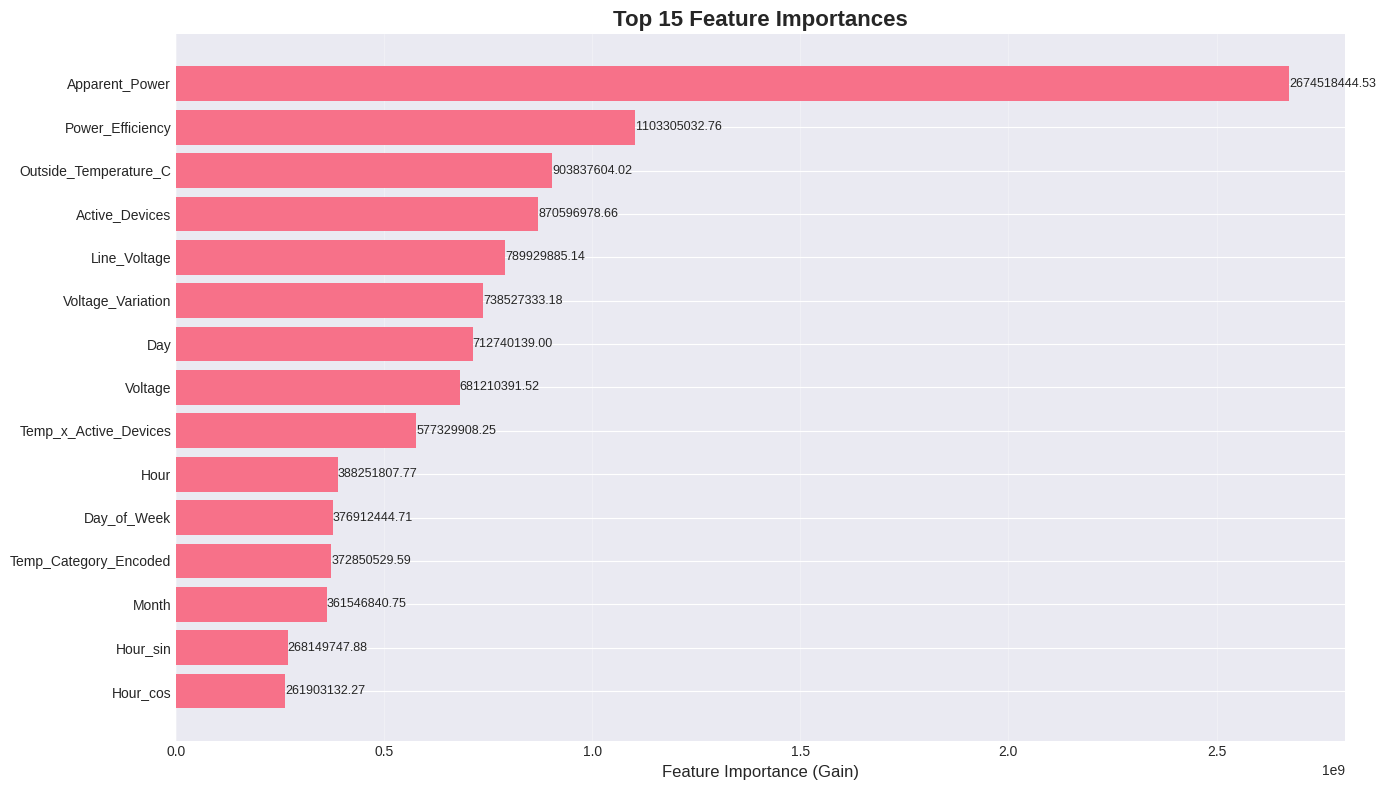

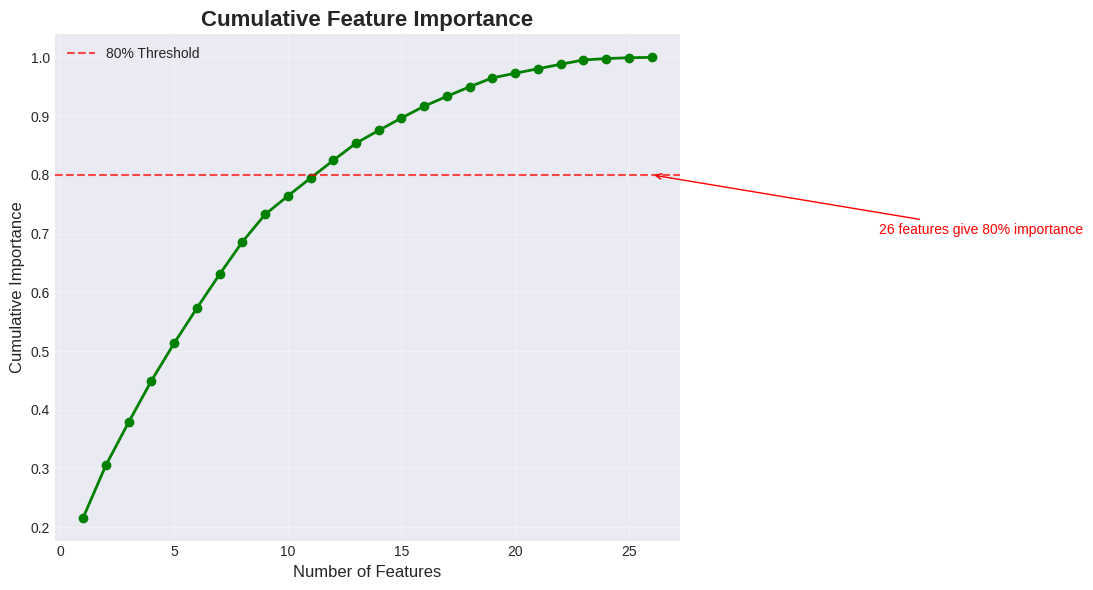

In [21]:
# Load feature importance if not already loaded
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': model.feature_importance(importance_type='gain')
}).sort_values('Importance', ascending=False)

# Plot top 15 features
top_n = 15
top_features = feature_importance.head(top_n)

plt.figure(figsize=(14, 8))
bars = plt.barh(range(len(top_features)), top_features['Importance'].values)
plt.yticks(range(len(top_features)), top_features['Feature'].values, fontsize=10)
plt.xlabel('Feature Importance (Gain)', fontsize=12)
plt.title(f'Top {top_n} Feature Importances', fontsize=16, fontweight='bold')

# Add value labels on bars
for i, (bar, value) in enumerate(zip(bars, top_features['Importance'].values)):
    plt.text(value, bar.get_y() + bar.get_height()/2,
             f'{value:.2f}', va='center', ha='left', fontsize=9)

plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

# Cumulative importance
cumulative_importance = feature_importance['Importance'].cumsum() / feature_importance['Importance'].sum()

plt.figure(figsize=(12, 6))
plt.plot(range(1, len(cumulative_importance) + 1), cumulative_importance,
         marker='o', linewidth=2, color='green')
plt.axhline(y=0.8, color='red', linestyle='--', alpha=0.7, label='80% Threshold')
plt.xlabel('Number of Features', fontsize=12)
plt.ylabel('Cumulative Importance', fontsize=12)
plt.title('Cumulative Feature Importance', fontsize=16, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend()

# Find how many features give 80% importance
features_80 = (cumulative_importance >= 0.8).idxmax() + 1
plt.annotate(f'{features_80} features give 80% importance',
             xy=(features_80, 0.8),
             xytext=(features_80 + 10, 0.7),
             arrowprops=dict(arrowstyle='->', color='red'),
             fontsize=10, color='red')

plt.tight_layout()
plt.show()

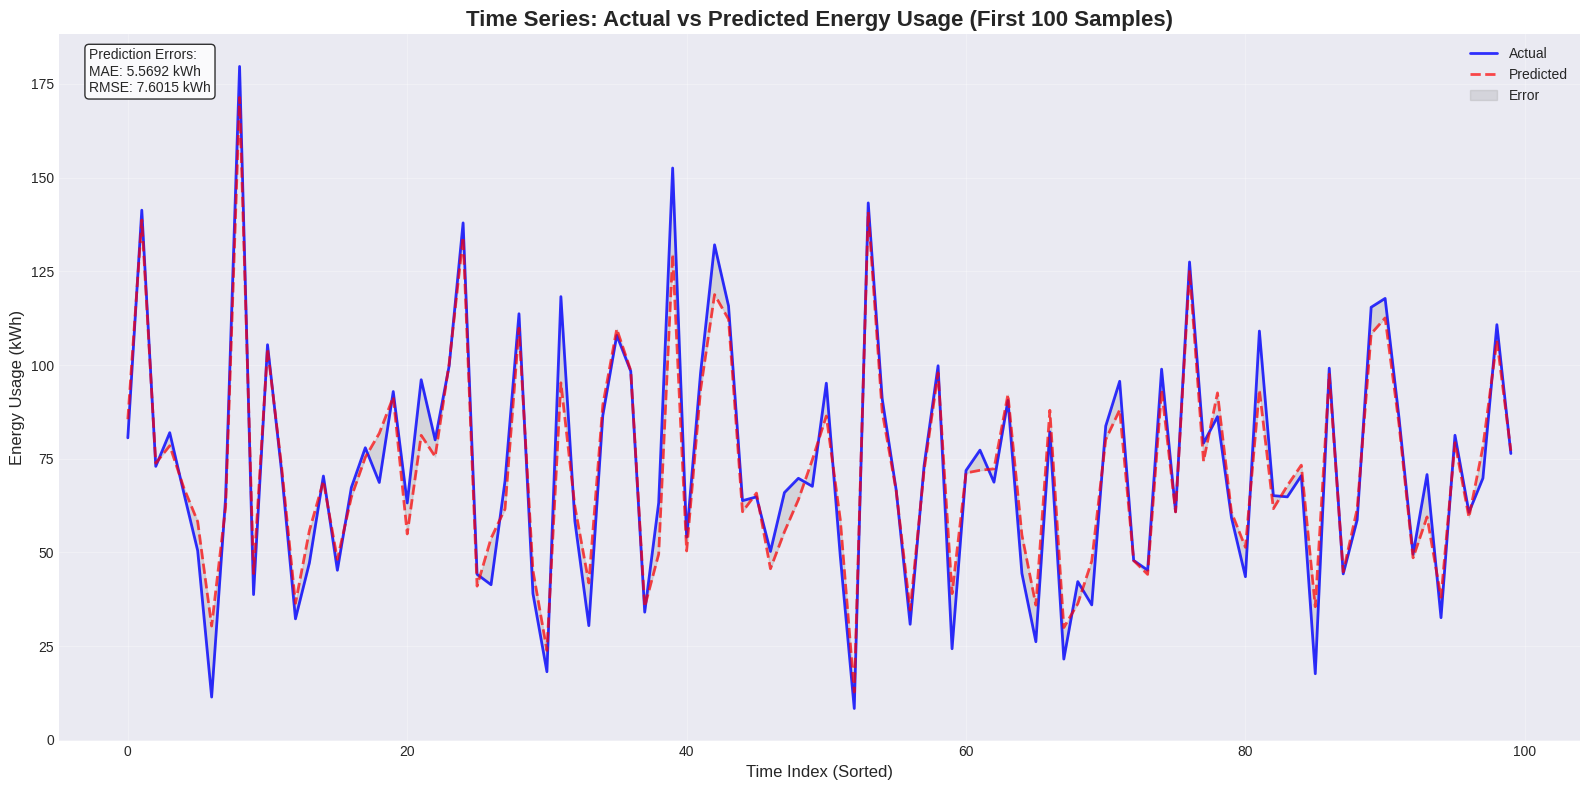

In [22]:
# Sort test set by time (assuming time-based index)
time_idx = np.argsort(y_test.index)
y_test_sorted = y_test.values[time_idx]
y_test_pred_sorted = y_test_pred[time_idx]

# Plot time series of predictions
plt.figure(figsize=(16, 8))

# Plot first 100 predictions for clarity
n_show = min(100, len(y_test_sorted))
plt.plot(range(n_show), y_test_sorted[:n_show],
         label='Actual', linewidth=2, color='blue', alpha=0.8)
plt.plot(range(n_show), y_test_pred_sorted[:n_show],
         label='Predicted', linewidth=2, color='red', alpha=0.7, linestyle='--')

# Fill between for error visualization
plt.fill_between(range(n_show),
                  y_test_sorted[:n_show],
                  y_test_pred_sorted[:n_show],
                  alpha=0.2, color='gray', label='Error')

plt.xlabel('Time Index (Sorted)', fontsize=12)
plt.ylabel('Energy Usage (kWh)', fontsize=12)
plt.title('Time Series: Actual vs Predicted Energy Usage (First 100 Samples)',
          fontsize=16, fontweight='bold')
plt.legend(loc='best')
plt.grid(True, alpha=0.3)

# Add error metrics in a box
error_text = f"""Prediction Errors:
MAE: {test_metrics['MAE']:.4f} kWh
RMSE: {test_metrics['RMSE']:.4f} kWh"""
plt.text(0.02, 0.98, error_text, transform=plt.gca().transAxes,
         fontsize=10, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

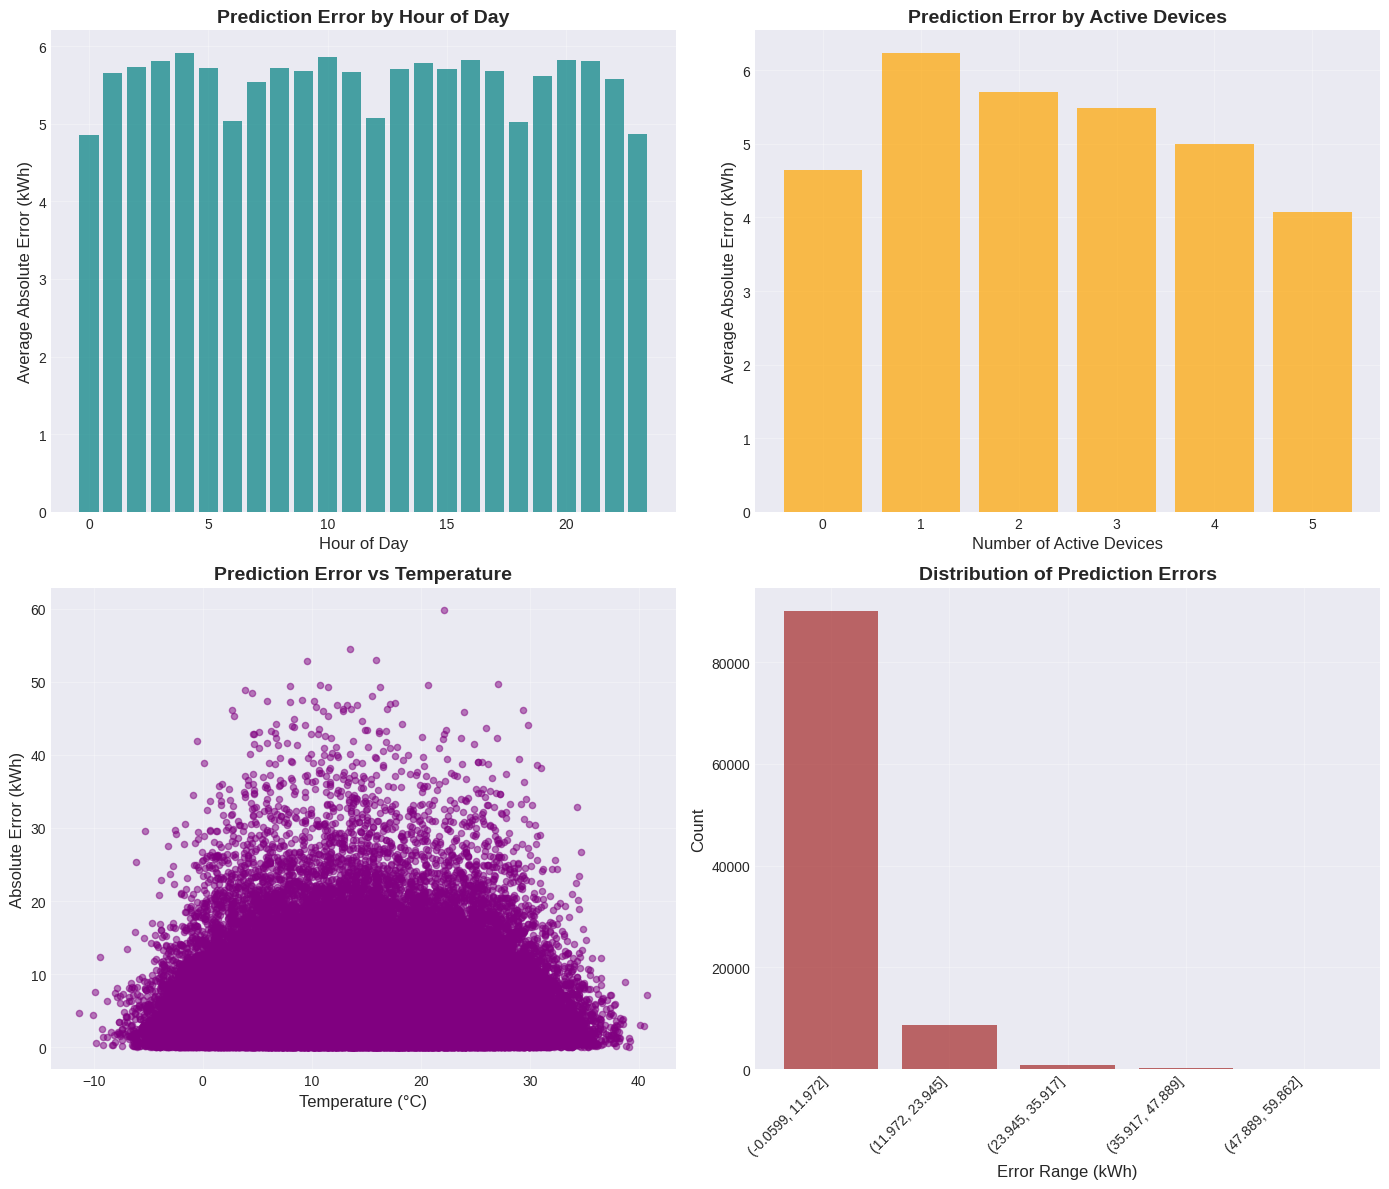

In [23]:
# Create DataFrame for error analysis
error_df = pd.DataFrame({
    'Actual': y_test.values,
    'Predicted': y_test_pred,
    'Error': residuals,
    'Abs_Error': np.abs(residuals),
    'Hour': df_features.loc[y_test.index, 'Hour'] if 'Hour' in df_features.columns else 0,
    'Active_Devices': df_features.loc[y_test.index, 'Active_Devices'] if 'Active_Devices' in df_features.columns else 0,
    'Temperature': df_features.loc[y_test.index, 'Outside_Temperature_C'] if 'Outside_Temperature_C' in df_features.columns else 0
})

# Plot error by hour
if 'Hour' in error_df.columns:
    fig, axes = plt.subplots(2, 2, figsize=(14, 12))

    # Error by hour
    error_by_hour = error_df.groupby('Hour')['Abs_Error'].mean()
    axes[0, 0].bar(error_by_hour.index, error_by_hour.values, alpha=0.7, color='teal')
    axes[0, 0].set_xlabel('Hour of Day', fontsize=12)
    axes[0, 0].set_ylabel('Average Absolute Error (kWh)', fontsize=12)
    axes[0, 0].set_title('Prediction Error by Hour of Day', fontsize=14, fontweight='bold')
    axes[0, 0].grid(True, alpha=0.3)

    # Error by active devices
    if 'Active_Devices' in error_df.columns:
        error_by_devices = error_df.groupby('Active_Devices')['Abs_Error'].mean()
        axes[0, 1].bar(error_by_devices.index, error_by_devices.values, alpha=0.7, color='orange')
        axes[0, 1].set_xlabel('Number of Active Devices', fontsize=12)
        axes[0, 1].set_ylabel('Average Absolute Error (kWh)', fontsize=12)
        axes[0, 1].set_title('Prediction Error by Active Devices', fontsize=14, fontweight='bold')
        axes[0, 1].grid(True, alpha=0.3)

    # Error vs Temperature
    if 'Temperature' in error_df.columns:
        axes[1, 0].scatter(error_df['Temperature'], error_df['Abs_Error'],
                          alpha=0.5, s=20, color='purple')
        axes[1, 0].set_xlabel('Temperature (°C)', fontsize=12)
        axes[1, 0].set_ylabel('Absolute Error (kWh)', fontsize=12)
        axes[1, 0].set_title('Prediction Error vs Temperature', fontsize=14, fontweight='bold')
        axes[1, 0].grid(True, alpha=0.3)

    # Error distribution by magnitude
    error_bins = pd.cut(error_df['Abs_Error'], bins=5)
    error_dist = error_df.groupby(error_bins).size()
    axes[1, 1].bar(range(len(error_dist)), error_dist.values, alpha=0.7, color='brown')
    axes[1, 1].set_xlabel('Error Range (kWh)', fontsize=12)
    axes[1, 1].set_ylabel('Count', fontsize=12)
    axes[1, 1].set_title('Distribution of Prediction Errors', fontsize=14, fontweight='bold')
    axes[1, 1].set_xticks(range(len(error_dist)))
    axes[1, 1].set_xticklabels([str(b) for b in error_dist.index], rotation=45, ha='right')
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

In [24]:
# Save all figures to files
import os

# Create directory for saved figures
save_dir = 'model_visualizations'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Get all figure numbers and save them
for fig_num in plt.get_fignums():
    fig = plt.figure(fig_num)
    fig.savefig(f'{save_dir}/figure_{fig_num}.png', dpi=300, bbox_inches='tight')

print(f"All visualizations saved to '{save_dir}' directory!")
print(f"Total figures saved: {len(plt.get_fignums())}")

All visualizations saved to 'model_visualizations' directory!
Total figures saved: 0


## Test Results!!!!!!

In [25]:
residuals_test = y_test.values - y_test_pred
results_df = pd.DataFrame({
    'Actual_Energy_kWh': y_test.values,
    'Predicted_Energy_kWh': y_test_pred,
    'Error_kWh': residuals_test,
    'Abs_Error_kWh': np.abs(residuals_test),
    'Error_Percent': (np.abs(residuals_test) / (y_test.values + 1e-6) * 100)
})

print(results_df.head(20).to_string())
print(f"  Mean Abs Error: {results_df['Abs_Error_kWh'].mean():.4f} kWh")
print(f"  Median Abs Error: {results_df['Abs_Error_kWh'].median():.4f} kWh")

    Actual_Energy_kWh  Predicted_Energy_kWh  Error_kWh  Abs_Error_kWh  Error_Percent
0          111.158564            109.410746   1.747818       1.747818       1.572365
1           86.168187             86.175075  -0.006888       0.006888       0.007993
2           20.266070             31.933195 -11.667124      11.667124      57.569740
3          123.801929            109.941217  13.860712      13.860712      11.195877
4           57.069740             61.682873  -4.613133       4.613133       8.083326
5           92.521748             92.032438   0.489310       0.489310       0.528860
6           60.853958             58.601220   2.252738       2.252738       3.701876
7          123.750134            108.555584  15.194549      15.194549      12.278410
8           93.353561             86.130398   7.223163       7.223163       7.737426
9           71.362803             62.916420   8.446384       8.446384      11.835835
10          66.238294             66.440584  -0.202290       0.20

## Save Test Results!!!!!

In [26]:
results_df.to_csv('test_predictions.csv', index=False)

## all Columns with it's importance factor!!!

In [27]:
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': model.feature_importance(importance_type='gain')
}).sort_values('Importance', ascending=False)

print(feature_importance.head(15).to_string(index=False))

feature_importance.to_csv('feature_importance.csv', index=False)

              Feature   Importance
       Apparent_Power 2.674518e+09
     Power_Efficiency 1.103305e+09
Outside_Temperature_C 9.038376e+08
       Active_Devices 8.705970e+08
         Line_Voltage 7.899299e+08
    Voltage_Variation 7.385273e+08
                  Day 7.127401e+08
              Voltage 6.812104e+08
Temp_x_Active_Devices 5.773299e+08
                 Hour 3.882518e+08
          Day_of_Week 3.769124e+08
Temp_Category_Encoded 3.728505e+08
                Month 3.615468e+08
             Hour_sin 2.681497e+08
             Hour_cos 2.619031e+08


## Model Artifacts!

In [ ]:
import pickle
import json

# Saved model
model.save_model('lightgbm_energy_model.txt')

# Saved metadata
metadata = {
    'features': X_train.columns.tolist(),
    'weather_mapping': {str(k): int(v) for k, v in weather_mapping.items()},
    'metrics': {
        'test_mae': float(test_metrics['MAE']),
        'test_r2': float(test_metrics['R2'])
    }
}

with open('model_metadata.json', 'w') as f:
    json.dump(metadata, f, indent=2)

# Saved encoders
with open('encoders.pkl', 'wb') as f:
    pickle.dump({'weather': weather_encoder, 'temp': temp_encoder}, f)